In [1]:
import math

import lightgbm
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor

from rshdmrgpr.rs_hdmr_gpr import *

This notebook supplements the research paper and the Code Manual:  
  
<font color='red'>**Random Sampling High Dimensional Model Representation Gaussian Process Regression (RS-HDMR-GPR): a code for representing multidimensional functions with lower-dimensional terms**</font>
    
The following sections contains code that generated the figures in Sections 3.1, 3.3 - 3.4.

In [2]:
def data_summary(data):
    data.info()
    print()
    print(data.memory_usage())
    print()
    for c in data.columns:
        print(f'{c:<10} Max Value: {data[c].max():<10.4f}  Min Value: {data[c].min():<10.4f}')

#### Section 3.1 - H<sub>2</sub>O Data Set.

In [3]:
data = load_data('h2o')

In [4]:
data.shape

(10001, 4)

In [5]:
# This is the shape of data
data.head(2)

,a1,a2,a3,out
0,0.93809,0.93809,-0.30414,0.01220
1,1.19886,0.95341,-0.58120,10835.41567


In [6]:
# Prints information regarding the data.
data_summary(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a1      10001 non-null  float64
 1   a2      10001 non-null  float64
 2   a3      10001 non-null  float64
 3   out     10001 non-null  float64
dtypes: float64(4)
memory usage: 312.7 KB

Index      128
a1       80008
a2       80008
a3       80008
out      80008
dtype: int64

a1         Max Value: 1.3877      Min Value: 0.7148    
a2         Max Value: 1.4134      Min Value: 0.7179    
a3         Max Value: 0.6211      Min Value: -0.9997   
out        Max Value: 19946.4188  Min Value: 0.0122    


In [7]:
scale = data['out'].max() - data['out'].min()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns=['a1', 'a2', 'a3', 'out'])
d = data.shape[1] - 1

In [8]:
# Picks out 500 entries for training
# If one want the results for 1000 points as in the paper, one can change train_size to equal 1000 instead of 500.
x_train, x_test, y_train, y_test = train_test_split(data_scaled.drop(columns=['out']), data_scaled['out'], train_size=500, test_size=None, random_state=42)

In [9]:
# Trains 4 models: The fulld-hdmr, 1d-hdmr, 2d-hdmr and the 2d*-hdmr
matrices, kernels = kernel_matrices(d, d, kernel_function=RBF, length_scale=0.6)
matrices1, kernels1 = kernel_matrices(1, d, kernel_function=RBF, length_scale=0.6)
matrices2, kernels2 = kernel_matrices(2, d, kernel_function=RBF, length_scale=0.6)
matrices3 = [np.array([[1, 0], [0, 1], [0, 1]]), np.array([[1, 0], [1, 0], [0, 1]]), np.array([[1, 0], [0, 1], [1, 0]])]
kernels3 = kernels2

In [10]:
# Initializes the Model classes for training
hdmr_f = RSHDMRGPR(matrices, kernels) 
hdmr1 = RSHDMRGPR(matrices1, kernels1)
hdmr2 = RSHDMRGPR(matrices2, kernels2)
hdmr3 = RSHDMRGPR(matrices3, kernels3)

In [11]:
# Trains the three models. The third model returns the rmse values on the training set across cycles. Number of cycles
# is default to 50.
# Note we have not set verbose level, meaning the training will print all the details. 
# The default level is 0 which shows all details of training.
hdmr_f.train(x_train, y_train, alphas=1e-11, cycles=1, scale_down=(0.2, 2))
_, df_rmse1 = hdmr1.train(x_train, y_train, alphas=1e-8, scale_down=(0.2, 2), report_loss=True)
_, df_rmse2 = hdmr2.train(x_train, y_train, alphas=1e-8, scale_down=(0.2, 2), report_loss=True)
_, df_rmse3 = hdmr3.train(x_train, y_train, alphas=1e-8, scale_down=(0.2, 2), report_loss=True)

Training iteration for CYCLE 1 has started.
Training component function: 1, Optimizer: None, Resulting length_scale: RBF(length_scale=0.6) + WhiteKernel(noise_level=1e-11)
Training completed. Total time for training is 0.07 seconds.
Training iteration for CYCLE 1 has started.
Training component function: 1, Optimizer: None, Resulting length_scale: RBF(length_scale=0.6) + WhiteKernel(noise_level=1e-08)
Training component function: 2, Optimizer: None, Resulting length_scale: RBF(length_scale=0.6) + WhiteKernel(noise_level=1e-08)
Training component function: 3, Optimizer: None, Resulting length_scale: RBF(length_scale=0.6) + WhiteKernel(noise_level=1e-08)
Training iteration for CYCLE 2 has started.
Training component function: 1, Optimizer: None, Resulting length_scale: RBF(length_scale=0.6) + WhiteKernel(noise_level=1e-08)
Training component function: 2, Optimizer: None, Resulting length_scale: RBF(length_scale=0.6) + WhiteKernel(noise_level=1e-08)
Training component function: 3, Optimiz

In [12]:
y_predf, y_errf = hdmr_f.predict(data_scaled.iloc[:, :3], return_std=True)
y_pred1, y_err1 = hdmr1.predict(data_scaled.iloc[:, :3], return_std=True)
y_pred2, y_err2 = hdmr2.predict(data_scaled.iloc[:, :3], return_std=True)
y_pred3, y_err3 = hdmr3.predict(data_scaled.iloc[:, :3], return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py

In [13]:
print(f'RMSE {scale * math.sqrt(mean_squared_error(data_scaled["out"], y_predf))}')
print(f'RMSE {scale * math.sqrt(mean_squared_error(data_scaled["out"], y_pred1))}')
print(f'RMSE {scale * math.sqrt(mean_squared_error(data_scaled["out"], y_pred2))}')
print(f'RMSE {scale * math.sqrt(mean_squared_error(data_scaled["out"], y_pred3))}')

RMSE 2.939389809117705
RMSE 459.89559477121463
RMSE 265.68934026485573
RMSE 47.49148207756749


In [14]:
models1 = hdmr1.get_models()
models2 = hdmr2.get_models()
models3 = hdmr3.get_models()

Root mean squared error is: 2.939389809117702


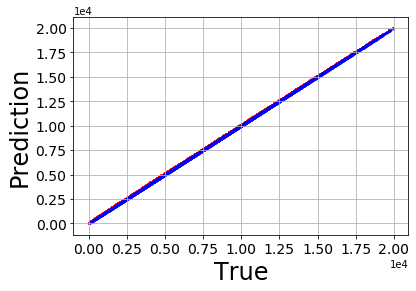

In [15]:
# Correlation plot for full-d-hdmr model.
correlation_plot(data_scaled.iloc[:, 3] * scale, y_predf * scale, y_errf * scale, xlabel='True', ylabel='Prediction', sn=True)

Root mean squared error is: 459.8955947712145


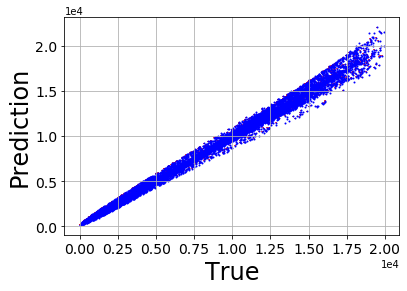

In [16]:
correlation_plot(data_scaled.iloc[:, 3] * scale, y_pred1 * scale, y_err1 * scale, xlabel='True', ylabel='Prediction', sn=True)

Root mean squared error is: 265.68934026485573


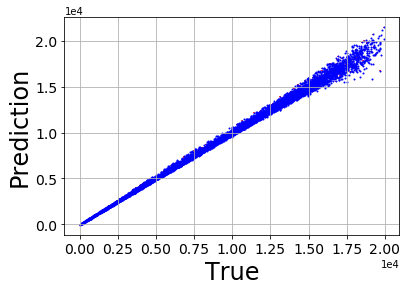

In [17]:
correlation_plot(data_scaled.iloc[:, 3]* scale, y_pred2 * scale, y_err2 * scale, xlabel='True', ylabel='Prediction', sn=True)

Root mean squared error is: 47.4914820775675


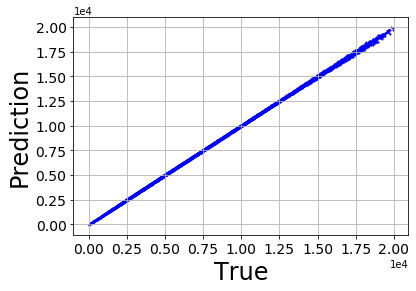

In [18]:
correlation_plot(data_scaled.iloc[:, 3]* scale, y_pred3 * scale, y_err3 * scale, xlabel='True', ylabel='Prediction', sn=True)

Root mean squared error is: 29.258319435044104


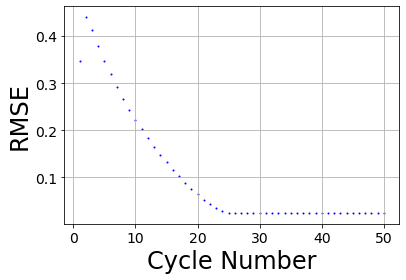

In [19]:
correlation_plot(df_rmse1['cycle_no'], df_rmse1['rmse'], xlabel='Cycle Number', ylabel='RMSE')
# correlation_plot(df_rmse1['cycle_no'], df_rmse1['rmse'], xlabel='Cycle Number', name='cycle1.png', save=True, ylabel='RMSE')

Root mean squared error is: 29.269413389564818


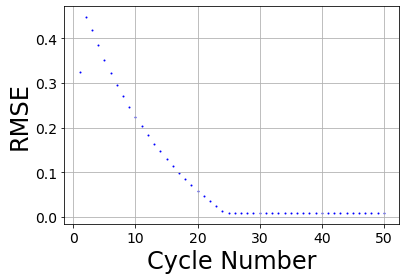

In [20]:
correlation_plot(df_rmse2['cycle_no'], df_rmse2['rmse'], xlabel='Cycle Number', ylabel='RMSE')
# correlation_plot(df_rmse2['cycle_no'], df_rmse2['rmse'], xlabel='Cycle Number', name='cycle2.png', save=True, ylabel='RMSE')

Root mean squared error is: 29.273946053285457


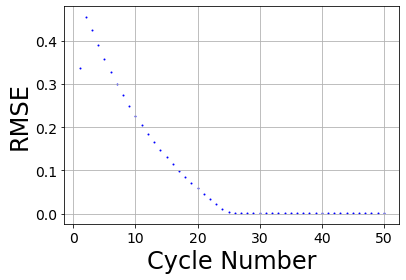

In [21]:
correlation_plot(df_rmse3['cycle_no'], df_rmse3['rmse'], xlabel='Cycle Number', ylabel='RMSE')
# correlation_plot(df_rmse3['cycle_no'], df_rmse3['rmse'], xlabel='Cycle Number', name='cycle3.png', save=True, ylabel='RMSE')

<span style='font-family:"Times New Roman"'> <span styel=''><font color='navy'>Component function graphs for the 1d-hdmr model</font>

Root mean squared error is: 0.32891019449709014
Root mean squared error is: 0.3189138960043383
Root mean squared error is: 0.39716786229098133


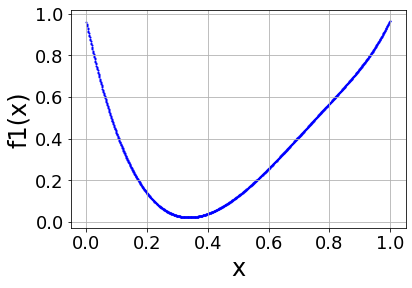

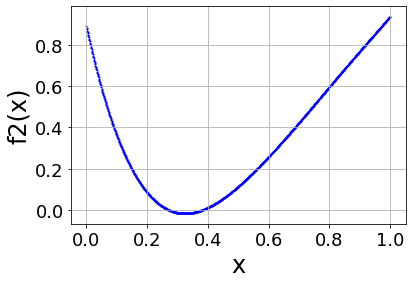

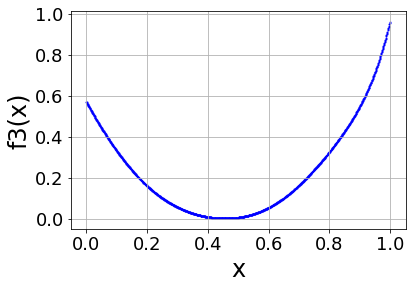

In [22]:
def f1(x, i):
    return models1[i].predict(np.array([[x]]))[0]
f1 = np.vectorize(f1)
x = np.arange(0, 1, 0.001)
for i in range(3):
    correlation_plot(x, f1(x, i), xlabel='x', ylabel=f'f{i+1}(x)', ticksize=18, figsize=(16, 10), display_rmse=False)
#     correlation_plot(x, f1(x, i), xlabel='x', ylabel=f'f{i+1}(x)', name=f'y = f{i+1}(x)', save=True, ticksize=18)

<span style='font-family:"Times New Roman"'> <span styel=''><font color='navy'>Component function graphs for the 2d-hdmr model</font>

In [23]:
def f2(x, y, i):
    return models2[i].predict(np.array([[x, y]]))[0]
f2 = np.vectorize(f2)

In [24]:
# Determines the maximum and minimum values for each feature. Used to set boundaries for the component functions.
print(max(f2(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], 0)), min(f2(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], 0)))
print(max(f2(data_scaled.iloc[:, 0], data_scaled.iloc[:, 2], 1)), min(f2(data_scaled.iloc[:, 0], data_scaled.iloc[:, 2], 1)))
print(max(f2(data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], 2)), min(f2(data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], 2)))

0.5951058166101575 -0.0016072755679488182
0.6115215830504894 0.00931400153785944
0.47945348639041185 -0.011373630724847317


C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Z contains NaN values. This may result in rendering artifacts.


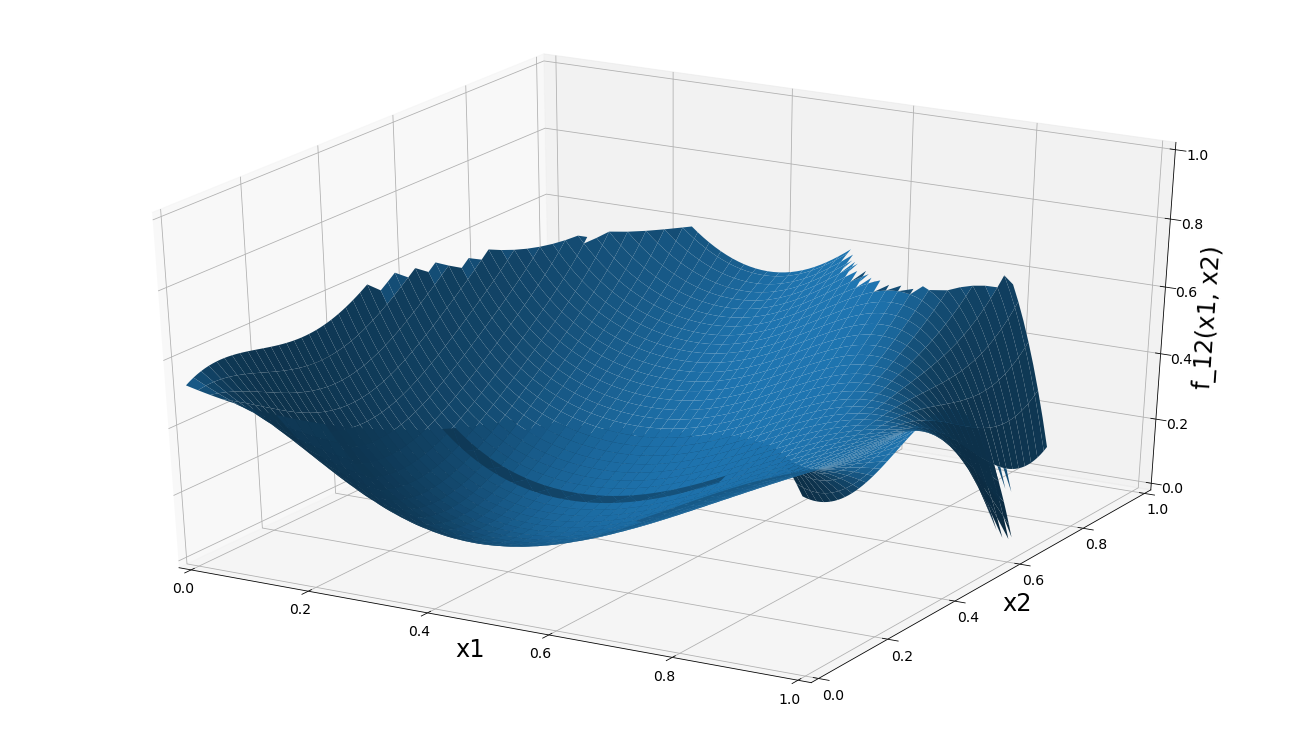

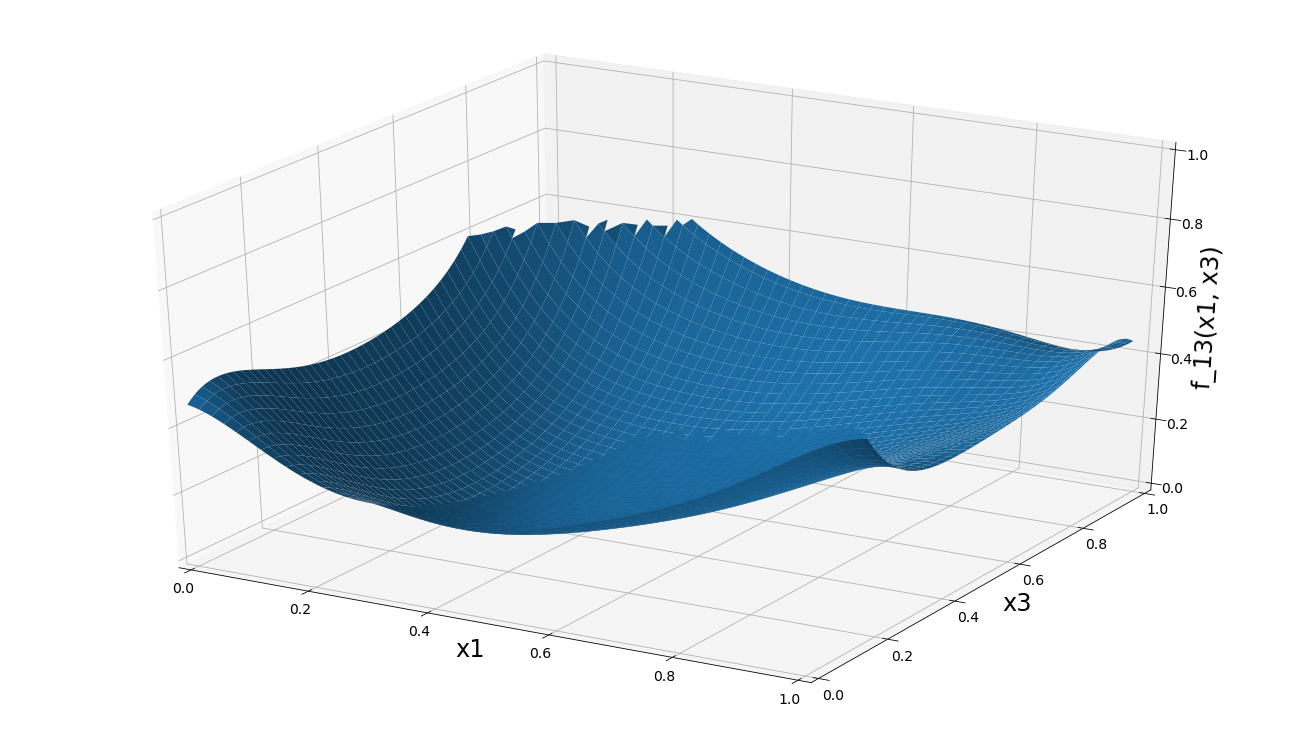

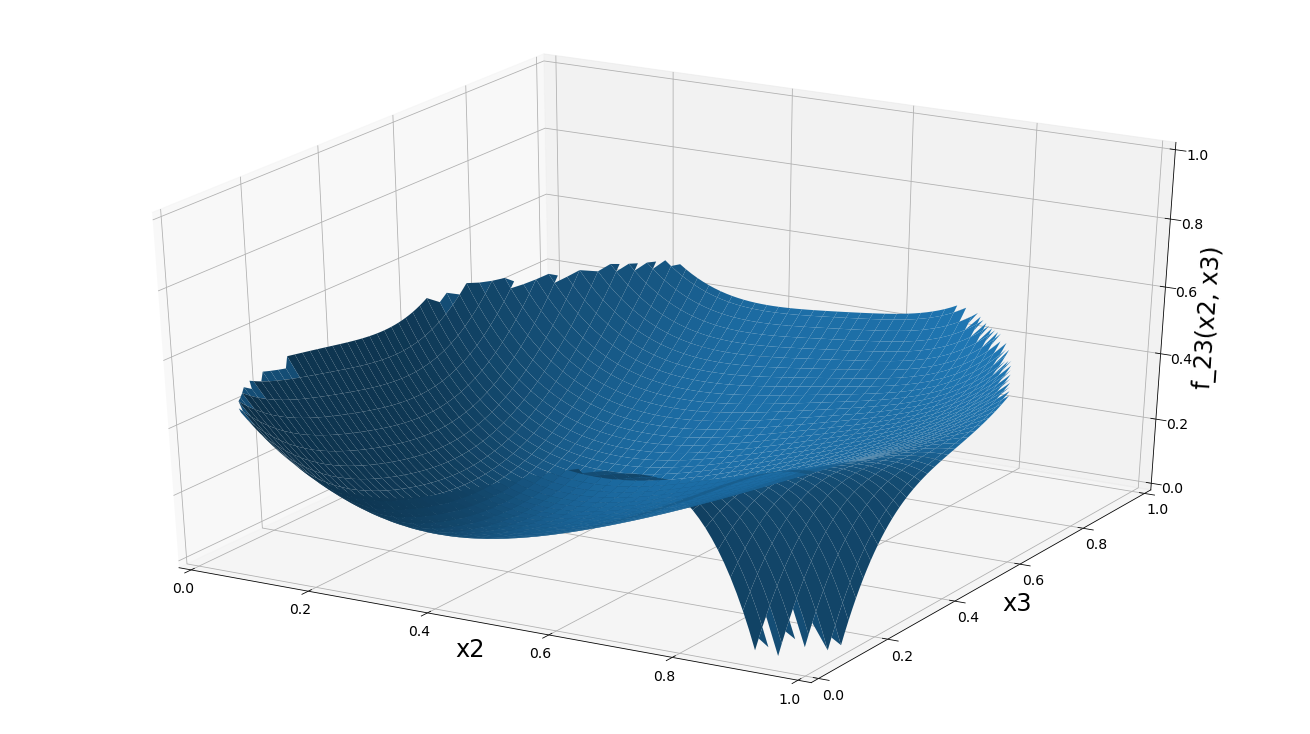

In [25]:
# saves the 2d-hdmr component function graphs.
l = [[1, 2], [1, 3], [2, 3]]
maxs = [0.5951312705874443, 0.6116230310872197, 0.4794613514095545]
mins = [-0.001606629230082035, 0.00931120477616787, -0.01137431338429451]
x = y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x,y)
for i in range(3):
    z = f2(x, y, i)
    for j in range(len(x)):
        for k in range(len(y)):
            if (z[k,j] < mins[i]) or (z[k,j] > maxs[i]):
                z[k,j] = np.nan

    fig = plt.figure(figsize=(18, 10))
#     fig = plt.figure()
    ax = Axes3D(fig)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_xlabel(f'x{l[i][0]}', fontsize=24)
    ax.set_ylabel(f'x{l[i][1]}', fontsize=24)
    ax.set_zlabel(f'f_{l[i][0]}{l[i][1]}(x{l[i][0]}, x{l[i][1]})', fontsize=24)
    ax.plot_surface(x, y, z)
#     plt.savefig(f'z=f_{l[i][0]}{l[i][1]}(x{l[i][0]}, x{l[i][1]}).png', dpi=800, bbox_inches='tight')

<span style='font-family:"Times New Roman"'> <span styel=''><font color='navy'>Component function graphs for the 2d*-hdmr model</font>

In [26]:
def f3(x, y, i):
    return models3[i].predict(np.array([[x, y]]))[0]
f3 = np.vectorize(f3)

In [27]:
print(max(f3(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1] + data_scaled.iloc[:, 2], 0)), min(f3(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1] + data_scaled.iloc[:, 2], 0)))
print(max(f3(data_scaled.iloc[:, 0] + data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], 1)), min(f3(data_scaled.iloc[:, 0] + data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], 1)))
print(max(f3(data_scaled.iloc[:, 0] + data_scaled.iloc[:, 2], data_scaled.iloc[:, 1], 2)), min(f3(data_scaled.iloc[:, 0] + data_scaled.iloc[:, 2], data_scaled.iloc[:, 1], 2)))

0.7526013846509159 -0.004452851600944996
0.6004586697090417 0.012518744450062513
0.7862713455688208 -0.01733488915488124


C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Z contains NaN values. This may result in rendering artifacts.


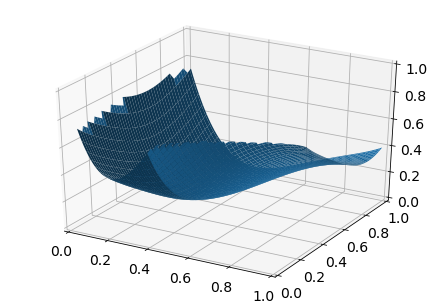

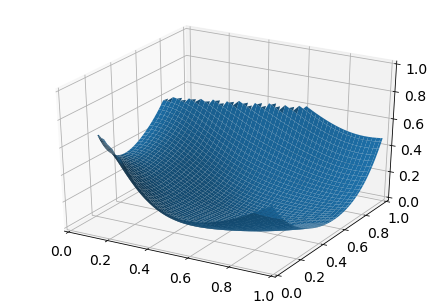

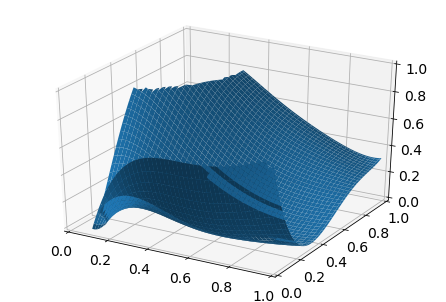

In [28]:
# saves the 2d*-hdmr component function graphs.
l = [['x1', 'x2 + x3'], ['x1 + x2', 'x3'], ['x1 + x3', 'x2']]
maxs = [0.7542398869991302, 0.6015302930027246, 0.7867522309534252]
mins = [-0.004734395071864128, 0.012315575033426285, -0.01638796553015709]
x = y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x, y)
for i in range(3):
    z = f3(x, y, i)
    for j in range(len(x)):
        for k in range(len(y)):
            if (z[k,j] < mins[i]) or (z[k,j] > maxs[i]):
                z[k,j] = np.nan

    fig = plt.figure(figsize=(18, 10))
#     fig = plt.figure()
    ax = Axes3D(fig)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
#     ax.set_xlabel(l[i][0], fontsize=24)
#     ax.set_ylabel(l[i][1], fontsize=24)
#     ax.set_zlabel(f'g{i+1}({l[i][0]}, {l[i][1]})', fontsize=24)
    ax.plot_surface(x, y, z)
#     plt.savefig(f'z=g{i+1}({l[i][0]}, {l[i][1]}).png', dpi=800, bbox_inches='tight')

#### Section 3.2 - Synthetic Dataset

In [29]:
# Below is the list of synthetic functions we will use:

# Sum of the argument function
def f0(*args):
    sumed = 0
    for a in [*args]:
        sumed += a
    
    return sumed
f0 = np.vectorize(f0)

# This function has 4 different possible inverse values in the region [0, 1]
def f1(x, y, z):
    return 0.05 * ((3.5 * (x - 0.5 ))**4 - (5.5 * x - 2.75) ** 2 + 1.6) + y + z
f1 = np.vectorize(f1)
def f2(x, y, z):
    return x**3 + y + z**5
f2 = np.vectorize(f2)
def f3(x, y, z):
    return x + 0.2 * x * y + y + z
f3 = np.vectorize(f3)

Example 1: f(x,y,z) = x + y + z

In [30]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f0(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=400, test_size=None, random_state=42)

In [31]:
# Trains the 1D hdmr on first 2000 points
# In this example, we choose verbose level 1 to print less details.
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, length_scale=0.6)
gpr = RSHDMRGPR(matrices, kernels)
gpr.train(x_train[:100].drop(columns=['out']), y_train[:100], alphas=1e-10, scale_down=(0.1, 1), verbose=1)

Training iteration for CYCLE 1 has started.
Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.
Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.
Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.
Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.
Training iteration for CYCLE 22 has started.
Training iteration 

In [32]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Root mean squared error is: 0.0026220468788954654


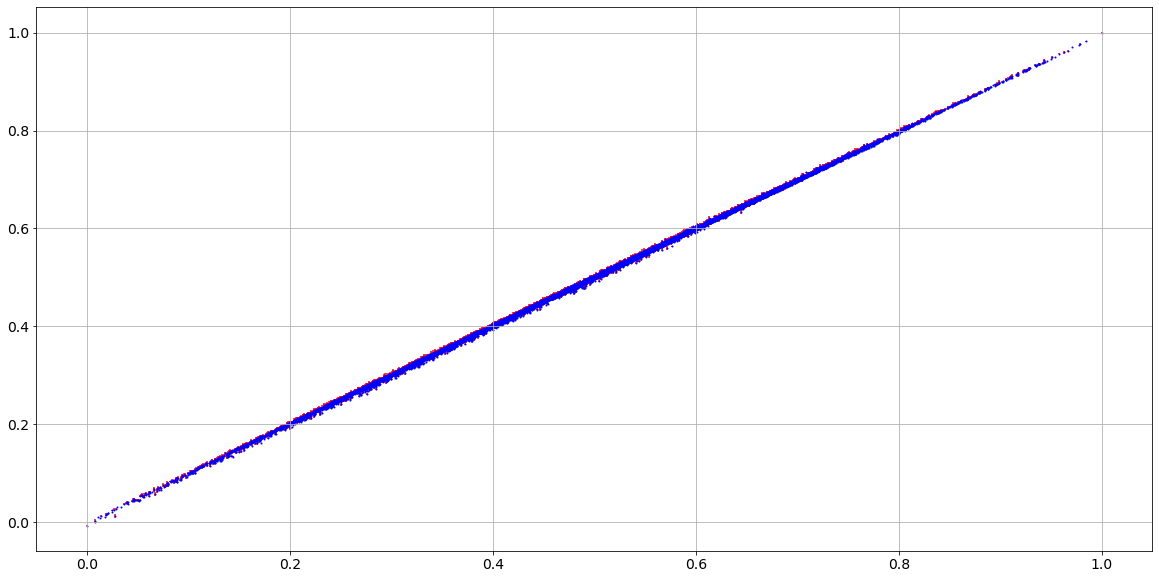

In [33]:
correlation_plot(data['out'], y_pred, y_err, figsize=(20, 10))

In [34]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.0026220468788954654


In [35]:
# Setting up DataFrame to be imputed.
df_na = x_train[100:].copy()
df_na.iloc[:100, 0] = np.nan
df_na.iloc[100: 200, 1] = np.nan
df_na.iloc[200: , 2] = np.nan

In [36]:
foimp = FirstOrderHDMRImpute(gpr.get_models())

In [37]:
# Appends the output columns for the component functions
foimp.get_yi(df_na)

Int64Index([1060, 3444, 1069, 2205, 9435, 7339, 8208, 7679, 4642, 7683,
            ...
            8322, 5578, 4426,  466, 6265, 5734, 5191, 5390,  860, 7270],
           dtype='int64', length=300)

In [38]:
# Imputes the missing values
foimp.impute(df_na)

Imputation function execution time took 17.2957444190979 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
1060,0.097000,0.289187,0.309807,0.207697,0.041891,0.085120,0.080686
3444,0.090000,0.693992,0.166414,0.292096,0.039287,0.223774,0.029035
1069,0.735000,0.439211,0.610547,0.590576,0.267027,0.138190,0.185359
2205,0.717000,0.199670,0.371271,0.415196,0.260708,0.051664,0.102825
9435,0.885000,0.410022,0.026904,0.425112,0.318902,0.128343,-0.022133
...,...,...,...,...,...,...,...
5734,0.418516,0.381491,0.083000,0.274092,0.153941,0.118511,0.001641
5191,0.195872,0.166974,0.572000,0.288233,0.075620,0.039794,0.172819
5390,0.050363,0.653340,0.863000,0.505121,0.023101,0.209589,0.272431
860,0.122921,0.888659,0.502000,0.490890,0.050218,0.292052,0.148620


Root mean squared error is: 0.0075232894797538025


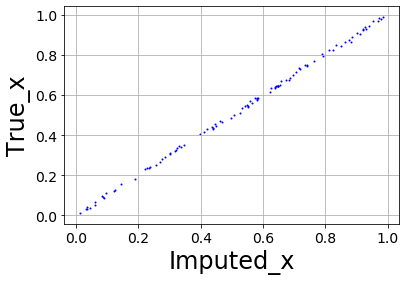

Root mean squared error is: 0.007944375644246866


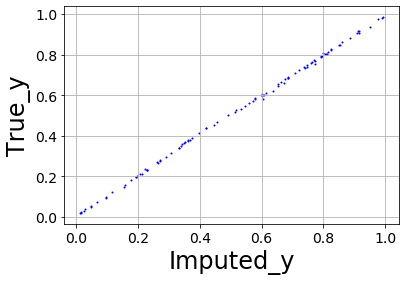

Root mean squared error is: 0.007404308118331533


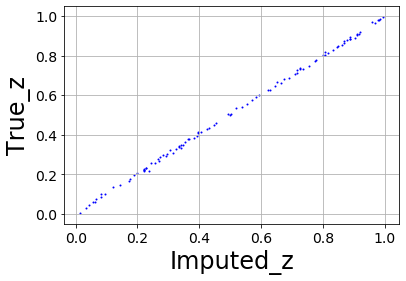

In [39]:
# To save the figure one can uncomment the commented out code
labels = ['x', 'y', 'z']
for i in range(3):
    correlation_plot(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}')
#    correlation_plot(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}', 
#                    name=f'Imputed_{labels[i]}.png', save=True)

In [40]:
# Trains the 1D hdmr on the training set concatenated with the imputed data.
# We set verbose level to 2 to print even less details for training. At this level, only a message will show for completed training.
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, length_scale=0.6)
gpr = RSHDMRGPR(matrices, kernels)
gpr.train(pd.concat([x_train[:100], df_na.iloc[:, :4]]).drop(columns=['out']), y_train, alphas=1e-10, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 2.01 seconds.


In [41]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [42]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.0027565045268621185


Example 2: f(x<sub>1</sub>, x<sub>2</sub>, ... , x<sub>15</sub>) = x<sub>1</sub> + x<sub>2</sub> + ... + x<sub>15</sub>

In [43]:
# Generates the 15D data.
column_names = []
n = 15
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
data = pd.DataFrame(np.random.rand(10000, 15), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f0(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=300, test_size=None, random_state=42)

In [44]:
# Trains the 1D hdmr on first 200 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, length_scale=0.6)
gpr = RSHDMRGPR(matrices, kernels)
gpr.train(x_train[:200].drop(columns=['out']), y_train[:200], alphas=1e-10, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 2.60 seconds.


In [45]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py

Root mean squared error is: 0.013562251553512752


<Figure size 1440x720 with 0 Axes>

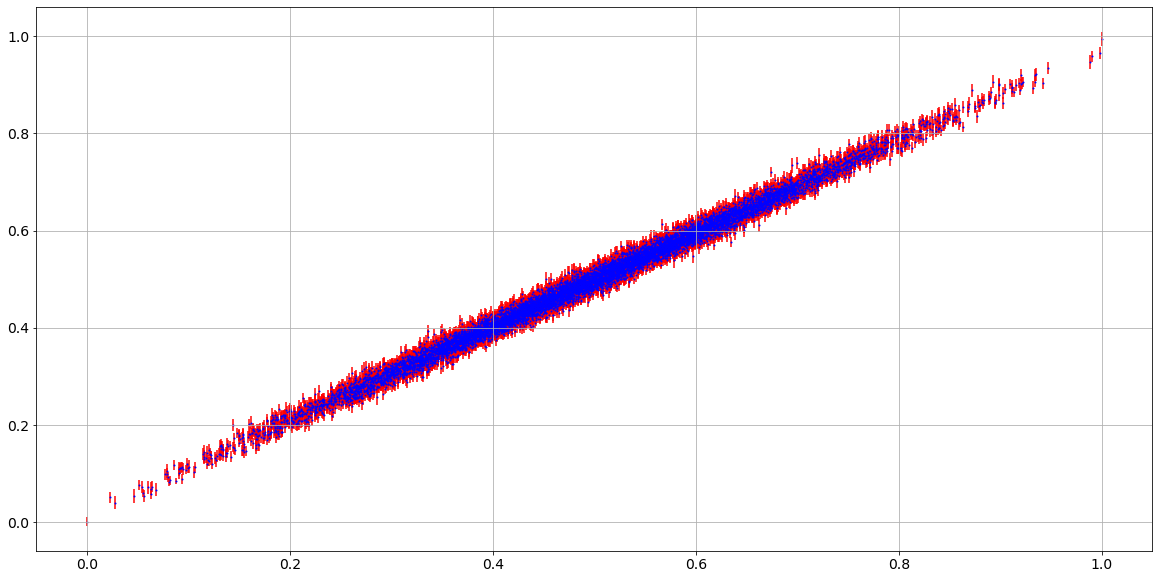

In [46]:
plt.figure(figsize=(20, 10))
correlation_plot(data['out'], y_pred, y_err, figsize=(20, 10))

In [47]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.013562251553512752


In [48]:
df_na = x_train[200:].copy()
df_na.iloc[:, 0] = np.nan

In [49]:
foimp = FirstOrderHDMRImpute(gpr.get_models())

In [50]:
foimp.get_yi(df_na)
foimp.impute(df_na)

Imputation function execution time took 5.698759078979492 seconds.


,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14
3099,0.949,0.175959,0.745513,0.306888,0.226071,0.557869,0.765125,0.726737,0.233756,0.330502,...,0.045862,0.064194,0.068309,0.002501,0.011170,0.072261,0.056131,0.051392,0.007200,0.064160
6184,0.342,0.275515,0.563927,0.524290,0.432415,0.776180,0.498164,0.978796,0.801812,0.106449,...,0.069562,0.032410,0.091497,0.069234,-0.015441,0.008445,0.036095,0.020665,-0.022861,0.031904
3561,0.754,0.589921,0.660171,0.019466,0.670514,0.388353,0.460214,0.808050,0.523794,0.986871,...,0.022362,0.027360,0.072872,0.039318,0.089484,0.067298,0.056587,0.039265,0.023505,-0.025855
5892,0.251,0.283753,0.007310,0.080278,0.397543,0.939762,0.994799,0.050120,0.830580,0.480258,...,0.094216,0.092969,-0.020869,0.071873,0.029758,0.052318,0.031194,0.086868,0.031841,-0.014214
391,0.432,0.732219,0.233019,0.813142,0.588431,0.210763,0.236720,0.628030,0.829940,0.415628,...,-0.001252,0.000855,0.051749,0.071811,0.020568,0.006288,0.073801,0.047555,0.027946,0.029084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.935,0.141108,0.323845,0.557732,0.003515,0.847278,0.369480,0.723398,0.769298,0.548083,...,0.077859,0.014258,0.067934,0.066556,0.039969,0.066935,0.052781,0.006932,0.071584,0.041143
5191,0.968,0.131844,0.452604,0.454769,0.456334,0.930704,0.327193,0.614273,0.896313,0.050539,...,0.092602,0.008960,0.048918,0.078920,-0.023697,0.073287,0.059982,-0.003104,0.013431,0.005549
5390,0.206,0.845841,0.304221,0.369807,0.801831,0.814177,0.400009,0.553825,0.679210,0.688607,...,0.073450,0.018591,0.037028,0.059603,0.057645,0.041111,0.070140,0.070097,0.075411,-0.001804
860,0.773,0.271484,0.038972,0.847790,0.863867,0.596231,0.574434,0.813120,0.786310,0.890105,...,0.051603,0.040802,0.072936,0.067921,0.082628,0.043559,0.088705,0.093593,-0.011633,0.071239


RMSE 0.10110093949137038
Root mean squared error is: 0.10110093949137038


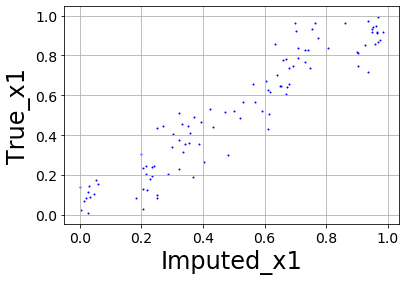

In [51]:
print(f'RMSE {math.sqrt(mean_squared_error(df_na.iloc[:, 0], x_train.iloc[200:, 0]))}')
correlation_plot(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1')
# plot_for_paper(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1', name=f'15d_imputed.png', save=True)

Example 3: f(x,y,z) = x + y + z With Noise (from a normal distribution) added to the output

In [52]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f0(*inputs)
data['out'] = data['out'] + 0.05 * np.random.randn(10000)  # Adds noise generated by a normal distribution with mean=0 and standard deviation=0.05
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=300, test_size=None, random_state=42)

In [53]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, length_scale=0.6)
gpr = RSHDMRGPR(matrices, kernels)
gpr.train(x_train[:200].drop(columns=['out']), y_train[:200], alphas=1e-10, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 0.44 seconds.


In [54]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [55]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.01770005642208302


Root mean squared error is: 0.01770005642208302


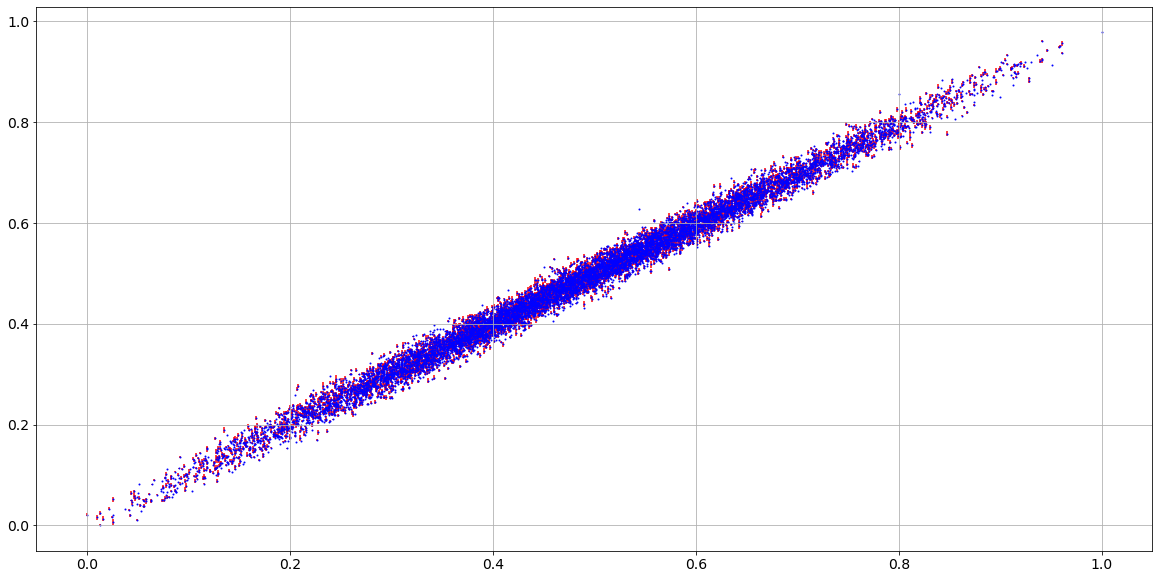

In [56]:
correlation_plot(data['out'], y_pred, y_err, figsize=(20, 10))

In [57]:
df_na = x_train[200:].copy()
df_na.iloc[:, 0] = np.nan

In [58]:
foimp = FirstOrderHDMRImpute(gpr.get_models())
foimp.get_yi(df_na)
foimp.impute(df_na)

Imputation function execution time took 5.8603270053863525 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
3099,0.823,0.943428,0.098495,0.605783,0.282685,0.308365,0.014734
6184,0.529,0.490203,0.361807,0.444268,0.182110,0.151200,0.110959
3561,0.658,0.439448,0.297847,0.450129,0.224029,0.135583,0.090517
5892,0.758,0.085398,0.626503,0.465955,0.257745,0.015418,0.192792
391,0.271,0.634006,0.539985,0.465640,0.098811,0.206491,0.160339
...,...,...,...,...,...,...,...
5734,0.431,0.381491,0.098209,0.282685,0.148719,0.119306,0.014659
5191,0.094,0.166974,0.575577,0.251972,0.037155,0.041623,0.173194
5390,0.000,0.653340,0.851426,0.480423,0.000074,0.213871,0.266478
860,0.119,0.888659,0.503084,0.479420,0.046129,0.284979,0.148312


RMSE 0.04899735650791944
Root mean squared error is: 0.04899735650791944


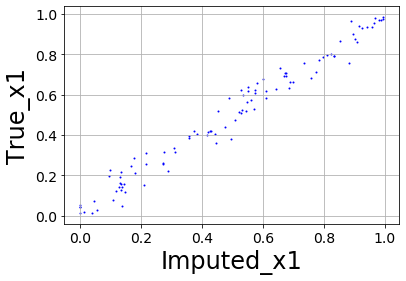

In [59]:
print(f'RMSE {math.sqrt(mean_squared_error(df_na.iloc[:, 0], x_train.iloc[200:, 0]))}')
correlation_plot(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1')
# plot_for_paper(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1', name=f'Imputed_x1.png', save=True)

Example 4: f(x,y,z) = x + y + z With Uneven Distribution for the features

In [60]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
# Generates data with bad distribution.
data = pd.DataFrame(np.concatenate([np.random.rand(5000, 3), 0.01 * np.random.randn(10000, 3) + 0.1]), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f0(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=300, test_size=None, random_state=42)

In [61]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, length_scale=0.6)
gpr = RSHDMRGPR(matrices, kernels)
gpr.train(x_train[:200].drop(columns=['out']), y_train[:200], alphas=1e-10, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 0.47 seconds.


In [62]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [63]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.005409858260358224


Root mean squared error is: 0.005409858260358224


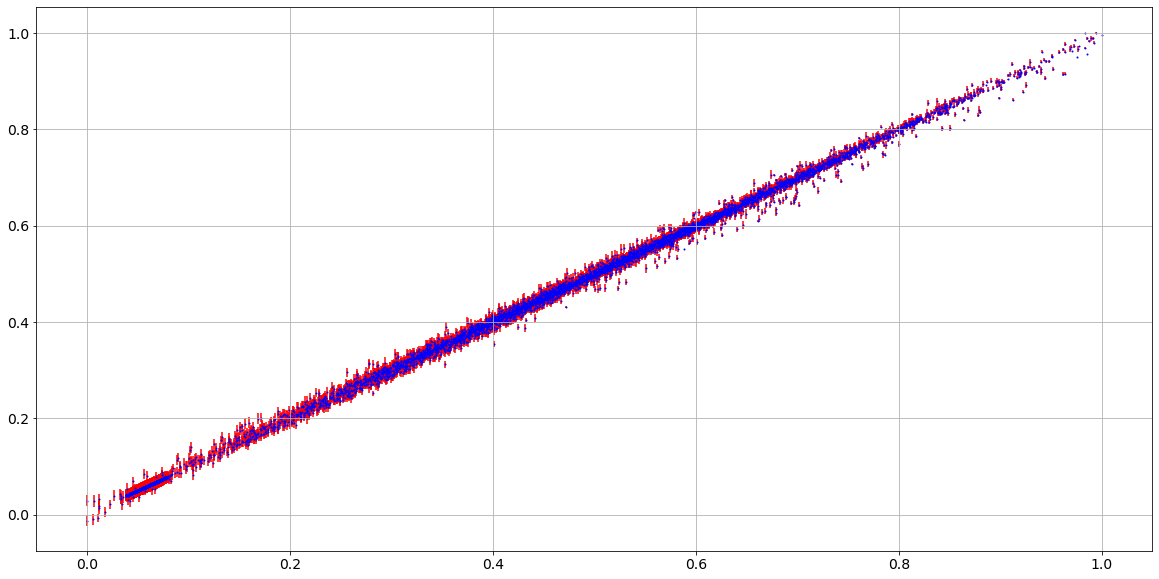

In [64]:
correlation_plot(data['out'], y_pred, y_err, figsize=(20, 10))

In [65]:
df_na = x_train[200:].copy()
df_na.iloc[:, 0] = np.nan

In [66]:
foimp = FirstOrderHDMRImpute(gpr.get_models())
foimp.get_yi(df_na)
foimp.impute(df_na)

Imputation function execution time took 5.756582498550415 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
14605,0.100,0.095966,0.081369,0.051562,0.021723,0.017881,0.011958
995,0.930,0.051669,0.504796,0.515360,0.351835,0.005017,0.158507
10173,0.118,0.096873,0.110376,0.068839,0.028221,0.018206,0.022412
4297,0.534,0.167368,0.978457,0.567533,0.186071,0.047765,0.333698
161,0.603,0.584314,0.901158,0.735100,0.214822,0.209573,0.310705
...,...,...,...,...,...,...,...
5191,0.094,0.107571,0.106899,0.062841,0.019386,0.022186,0.021269
13418,0.113,0.117338,0.117405,0.077336,0.026651,0.026029,0.024657
5390,0.099,0.094726,0.115429,0.062810,0.021337,0.017440,0.024033
860,0.134,0.888659,0.503084,0.512066,0.035041,0.319116,0.157909


Root mean squared error is: 0.015673298161566884


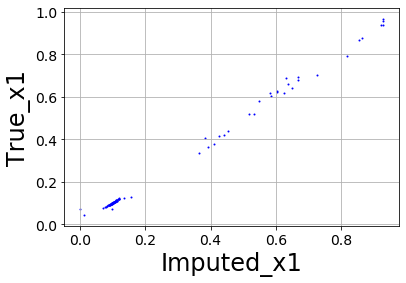

In [67]:
# plot_for_paper(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1', name=f'Imputed_x1.png', save=True)
correlation_plot(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1')

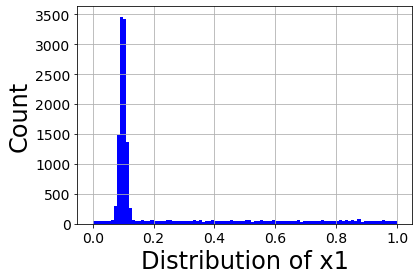

In [68]:
# Plots the distribution of the first feature
plt.figure()
data.iloc[:, 0].hist(bins=100, color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Distribution of x1', size=24)
plt.ylabel('Count', size=24)
plt.show()
# plt.savefig('hist.png', dpi=800, bbox_inches='tight')

Example 5: f(x, y, z) = x^3 + y + z^5

In [69]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f2(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=400, test_size=None, random_state=42)

In [70]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, length_scale=0.6)
gpr = RSHDMRGPR(matrices, kernels)
gpr.train(x_train[:100].drop(columns=['out']), y_train[:100], alphas=1e-10, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 0.28 seconds.


In [71]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [72]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.0027787630936977597


Root mean squared error is: 0.0027787630936977597


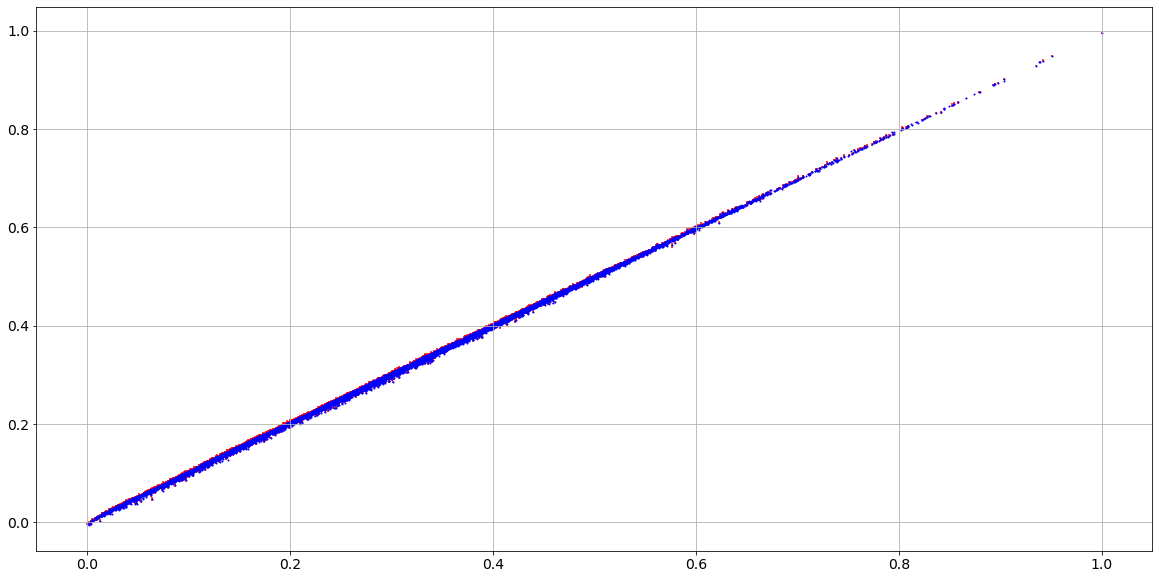

In [73]:
correlation_plot(data['out'], y_pred, y_err, figsize=(20, 10))

In [74]:
df_na = x_train[100:].copy()
df_na.iloc[:100, 0] = np.nan
df_na.iloc[100: 200, 1] = np.nan
df_na.iloc[200: , 2] = np.nan

In [75]:
foimp = FirstOrderHDMRImpute(gpr.get_models())

In [76]:
foimp.get_yi(df_na)

Int64Index([1060, 3444, 1069, 2205, 9435, 7339, 8208, 7679, 4642, 7683,
            ...
            8322, 5578, 4426,  466, 6265, 5734, 5191, 5390,  860, 7270],
           dtype='int64', length=300)

In [77]:
foimp.impute(df_na)

Imputation function execution time took 17.194015979766846 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
1060,0.027000,0.289187,0.309807,0.099675,0.032898,0.028092,0.038686
3444,0.089000,0.693992,0.166414,0.237329,0.038037,0.163166,0.036127
1069,0.740000,0.439211,0.610547,0.322483,0.176301,0.080291,0.065891
2205,0.721000,0.199670,0.371271,0.202529,0.165847,-0.004129,0.040811
9435,0.890000,0.410022,0.026904,0.381980,0.277499,0.070517,0.033965
...,...,...,...,...,...,...,...
5734,0.418516,0.381491,0.016000,0.155026,0.061254,0.060785,0.032987
5191,0.195872,0.166974,0.566000,0.080566,0.038259,-0.015491,0.057797
5390,0.050363,0.653340,0.855000,0.376577,0.035219,0.149774,0.191585
860,0.122921,0.888659,0.488000,0.315483,0.037192,0.230232,0.048060


Root mean squared error is: 0.02507770155766697


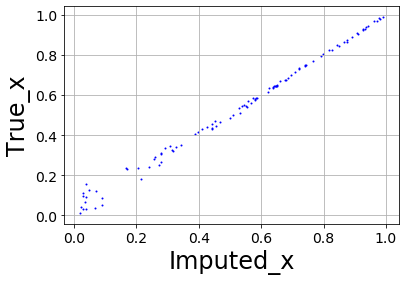

Root mean squared error is: 0.008573344538442194


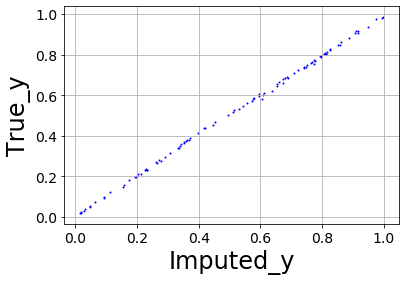

Root mean squared error is: 0.1282863251886373


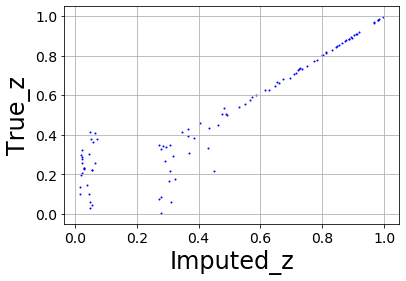

In [78]:
labels = ['x', 'y', 'z']
for i in range(3):
    correlation_plot(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}')
#     plot_for_paper(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}', 
#                    name=f'Imputed_{labels[i]}', save=True)

Example 6: f(x, y, z) =  0.05(3.5(x - 0.5 ))<sup>4</sup> - (5.5 x - 2.75)<sup>2</sup> + 1.6) + y + z

In [79]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f1(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=400, test_size=None, random_state=42)

In [80]:
# We graph the first component of f:
def g(x):
    return 0.5 * ((3.5 * (x - 0.5)) ** 4 - (5.5 * (x - 0.5)) ** 2 + 1.6)

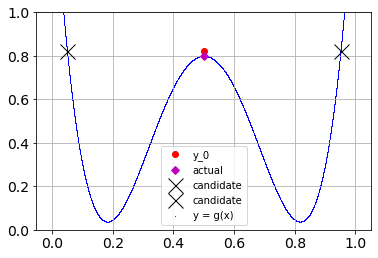

In [81]:
x = np.arange(0, 1, 0.0001)
# plt.xlabel('x', s=24)
# plt.ylabel('g(x)', s=24)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(0.5, 0.82, marker='o', color='r', label='y_0', lw=0)
plt.plot(0.5, 0.8, marker='D', color='m', label='actual', lw=0)
plt.plot(0.049, 0.82, marker='x', color='k', markersize=15, label='candidate', lw=0)
plt.plot(0.951, 0.82, marker='x', color='k', markersize=15, label='candidate', lw=0)
plt.scatter(x, g(x), s=1, c='b', label='y = g(x)', lw=0)
plt.grid()
plt.legend()
plt.show()
# plt.savefig('outlier.png', dpi=800)

In [82]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, length_scale=0.6)
gpr = RSHDMRGPR(matrices, kernels)
gpr.train(x_train.drop(columns=['out']), y_train, alphas=1e-10, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 1.99 seconds.


In [83]:
df_na = x_train.copy()
df_na.iloc[np.arange(0, 200, 2), 0] = np.nan

In [84]:
models = gpr.get_models()

In [85]:
foimp = FirstOrderHDMRImpute(models)

In [86]:
foimp.get_yi(df_na)

Int64Index([1664, 1931, 1150, 5949, 8932, 5177, 8311, 9850, 4465, 7987, 6966,
            7027,  876, 5315,    4, 5691, 2491, 4777, 6457, 1148, 3769,  853,
            9358, 6002, 4495, 6655, 4780, 2950, 6971, 1841,  537, 5801, 7206,
            7560,  784,  154, 3009, 4014, 3863, 1895,  569, 5854, 8319, 3327,
            6102,  980, 9331,  699,  606, 3420, 1060, 1069, 9435, 8208, 4642,
            9007, 5600, 7022,  225, 5895, 3436, 6893, 3446, 9146, 4735, 1218,
            9719, 4911, 4493, 5699,  956, 4433, 2961,   98, 2557, 4199, 5539,
            6197, 4499, 2255, 7400, 3108, 5423, 9208, 9797, 4061, 6616, 8155,
            4736, 6694, 1959, 8680, 1734, 8338, 9561, 7098,  659, 4282, 8800,
            1930],
           dtype='int64')

In [87]:
_, nan_rows_index, null_entry, candidates = foimp.impute(df_na, get_candidates=True)

Imputation function execution time took 6.040843486785889 seconds.


In [88]:
null_entry

1664    a0
1931    a0
1150    a0
5949    a0
8932    a0
        ..
7098    a0
659     a0
4282    a0
8800    a0
1930    a0
Length: 100, dtype: object

In [89]:
print(type(nan_rows_index), type(null_entry), type(candidates))

<class 'pandas.core.indexes.numeric.Int64Index'> <class 'pandas.core.series.Series'> <class 'list'>


In [90]:
true = x_train.iloc[np.arange(0, 200, 2), 0]

In [91]:
correct = []
correct_idxs = []
for i in range(true.shape[0]):
    true_val = true.iloc[i]
    closests = []
    for j in candidates[i]:
        closests.append(abs(j - true_val))
    idx = closests.index(min(closests))
    correct_idxs.append(idx)
    correct.append(candidates[i][idx])

In [92]:
# get the wrong imputations
out_idx = []
for i in range(len(true)):
    if abs(true.iloc[i] - correct[i]) > 0.2:
        out_idx.append(i)

In [93]:
t = []
im = []
c = []
m = 0
choices = pd.DataFrame(columns=['true', 'imputed', 'correct'])
for i in range(len(correct)):
    can = candidates[i]
    t.extend([true.iloc[i]] * len(can))
    c.extend([False] * len(can))
    for j in range(len(can)):
        im.append(can[j])
    c[m + correct_idxs[i]] = True
    m += len(can)
choices['true'] = t
choices['imputed'] = im
choices['correct'] = c

In [94]:
false_choices = choices[choices['correct'] == False]
true_choices = choices[choices['correct'] == True]

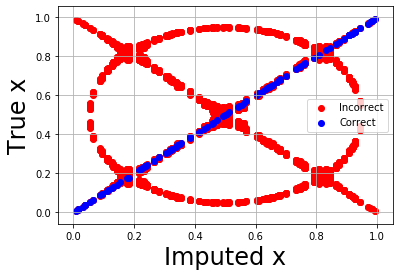

In [95]:
plt.figure()
plt.xlabel('Imputed x', fontsize=24)
plt.ylabel('True x', fontsize=24)
p1 = plt.scatter(false_choices['true'], false_choices['imputed'], c='r')
p2 = plt.scatter(true_choices['true'], true_choices['imputed'], c='b')
plt.grid()
plt.legend((p1, p2), ('Incorrect', 'Correct'))
plt.show()
# plt.savefig('choices.png', dpi=800, bbox_inches='tight')

Example 7: f(x, y, z) = x + 0.2xy + y + z

In [96]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
# data = pd.DataFrame(np.concatenate([np.random.rand(5000, 3), 0.01 * np.random.randn(10000, 3) + 0.1]), columns=column_names)
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f3(*inputs)
# data['out'] = data['out'] + 0.05 * np.random.randn(10000)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=400, test_size=None, random_state=42)

In [97]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, length_scale=0.6)
gpr = RSHDMRGPR(matrices, kernels)
gpr.train(x_train[:100].drop(columns=['out']), y_train[:100], alphas=1e-10, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 0.28 seconds.


In [98]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [99]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.006732146302307136


Root mean squared error is: 0.006732146302307136


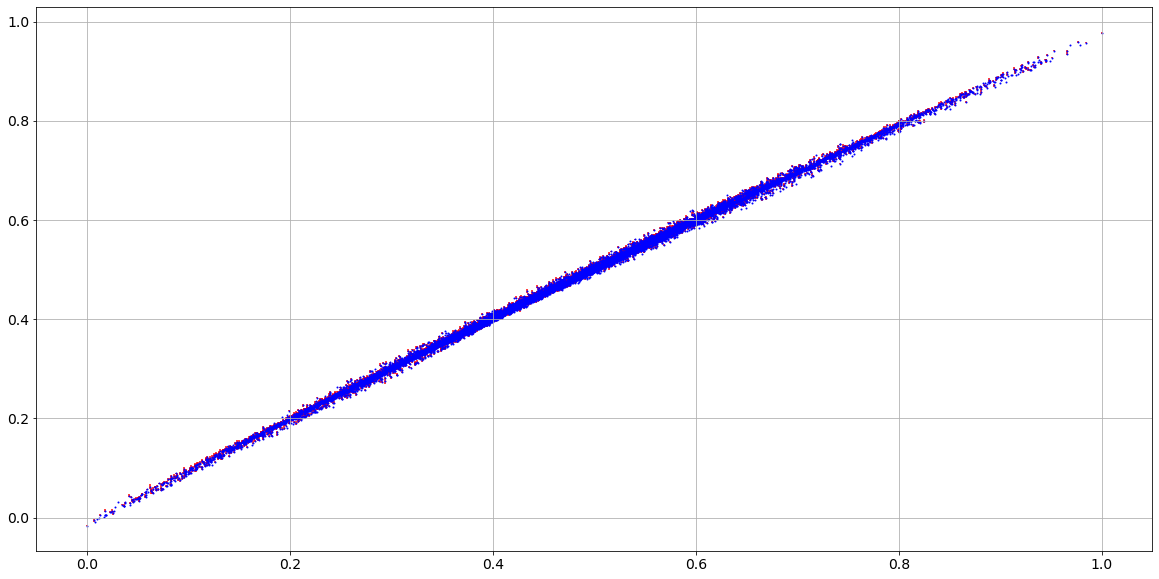

In [100]:
correlation_plot(data['out'], y_pred, y_err, figsize=(20, 10))

In [101]:
df_na = x_train[100:].copy()
df_na.iloc[:100, 0] = np.nan
df_na.iloc[100: 200, 1] = np.nan
df_na.iloc[200: , 2] = np.nan

In [102]:
foimp = FirstOrderHDMRImpute(gpr.get_models())

In [103]:
foimp.get_yi(df_na)

Int64Index([1060, 3444, 1069, 2205, 9435, 7339, 8208, 7679, 4642, 7683,
            ...
            8322, 5578, 4426,  466, 6265, 5734, 5191, 5390,  860, 7270],
           dtype='int64', length=300)

In [104]:
foimp.impute(df_na)

Imputation function execution time took 17.29265570640564 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
1060,0.109000,0.289187,0.309807,0.196426,0.036213,0.079098,0.081115
3444,0.086000,0.693992,0.166414,0.277434,0.027414,0.220873,0.029148
1069,0.734000,0.439211,0.610547,0.574553,0.264424,0.132245,0.177883
2205,0.696000,0.199670,0.371271,0.398234,0.250271,0.045633,0.102331
9435,0.873000,0.410022,0.026904,0.421996,0.313030,0.122147,-0.013180
...,...,...,...,...,...,...,...
5734,0.418516,0.381491,0.089000,0.267021,0.147104,0.112178,0.007740
5191,0.195872,0.166974,0.586000,0.271901,0.068530,0.033143,0.170228
5390,0.050363,0.653340,0.853000,0.475037,0.012249,0.206163,0.256625
860,0.122921,0.888659,0.473000,0.466737,0.040892,0.291251,0.134595


Root mean squared error is: 0.01879211085894254


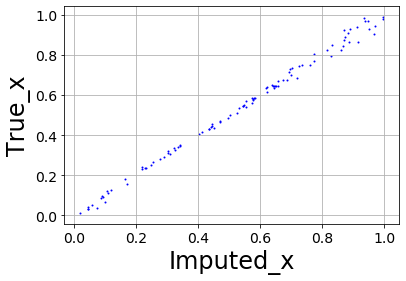

Root mean squared error is: 0.017191804466919553


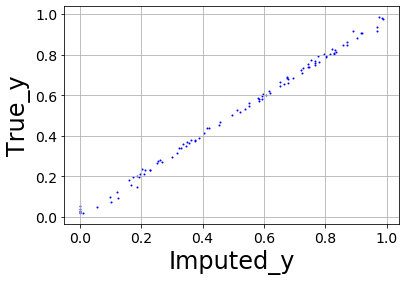

Root mean squared error is: 0.021626571390092133


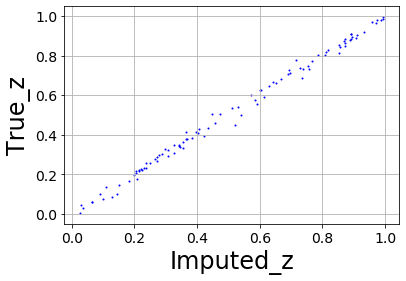

In [105]:
labels = ['x', 'y', 'z']
for i in range(3):
#     plot_for_paper(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}', name=f'Imputed_{labels[i]}', save=True)
    correlation_plot(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}')

#### Section 3.3 -- Example from Quantitative Finance

In [106]:
df_finance = load_data('financial')
df_finance = df_finance.rename(columns={'^GSPC': 'out'})
cols = [col for col in df_finance.columns if col != 'out'] + ['out']
df_finance = df_finance[cols]

In [107]:
data_summary(df_finance)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPI       3927 non-null   float64
 1   ^IRX      3927 non-null   float64
 2   GLD       3927 non-null   float64
 3   HUC.TO    3927 non-null   float64
 4   AGG       3927 non-null   float64
 5   ^VIX      3927 non-null   float64
 6   ^N225     3927 non-null   float64
 7   ^GDAXI    3927 non-null   float64
 8   ^IXIC     3927 non-null   float64
 9   CADUSD=X  3927 non-null   float64
 10  JPYUSD=X  3927 non-null   float64
 11  USDEUR=X  3927 non-null   float64
 12  USDCNY=X  3927 non-null   float64
 13  M2        3927 non-null   float64
 14  out       3927 non-null   float64
dtypes: float64(15)
memory usage: 460.3 KB

Index         128
CPI         31416
^IRX        31416
GLD         31416
HUC.TO      31416
AGG         31416
^VIX        31416
^N225       31416
^GDAXI      31416
^IXIC       31416
CADUSD

In [108]:
df_finance.corr()

,CPI,^IRX,GLD,HUC.TO,AGG,^VIX,^N225,^GDAXI,^IXIC,CADUSD=X,JPYUSD=X,USDEUR=X,USDCNY=X,M2,out
CPI,1.000000,0.751786,-0.079155,-0.694704,0.377789,-0.352083,0.863191,0.897056,0.888830,-0.754783,-0.631979,0.695787,0.315066,0.865202,0.923076
^IRX,0.751786,1.000000,-0.185967,-0.496567,-0.103625,-0.197115,0.690325,0.651377,0.735784,-0.578565,-0.408020,0.452702,0.510839,0.635846,0.743467
GLD,-0.079155,-0.185967,1.000000,0.297826,0.513898,0.323361,-0.415465,-0.344798,-0.119169,0.446256,0.666869,-0.314100,-0.071315,-0.084999,-0.186922
HUC.TO,-0.694704,-0.496567,0.297826,1.000000,-0.407461,-0.018465,-0.795348,-0.771835,-0.775763,0.937069,0.731533,-0.896541,-0.527804,-0.838030,-0.775026
AGG,0.377789,-0.103625,0.513898,-0.407461,1.000000,0.153394,0.196764,0.261914,0.384452,-0.282884,-0.096777,0.408241,0.130430,0.487477,0.354258
^VIX,-0.352083,-0.197115,0.323361,-0.018465,0.153394,1.000000,-0.270949,-0.381582,-0.114516,0.079508,0.296445,-0.101815,0.215643,-0.058318,-0.211591
^N225,0.863191,0.690325,-0.415465,-0.795348,0.196764,-0.270949,1.000000,0.968564,0.925783,-0.895107,-0.883208,0.760805,0.361402,0.897100,0.953616
^GDAXI,0.897056,0.651377,-0.344798,-0.771835,0.261914,-0.381582,0.968564,1.000000,0.905273,-0.859375,-0.836991,0.753889,0.309368,0.884163,0.943886
^IXIC,0.888830,0.735784,-0.119169,-0.775763,0.384452,-0.114516,0.925783,0.905273,1.000000,-0.840608,-0.695558,0.716111,0.509207,0.971749,0.989130
CADUSD=X,-0.754783,-0.578565,0.446256,0.937069,-0.282884,0.079508,-0.895107,-0.859375,-0.840608,1.000000,0.849995,-0.898207,-0.495202,-0.874488,-0.856308


In [109]:
scale = df_finance['out'].max() - df_finance['out'].min()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_finance)
data_scaled = pd.DataFrame(scaler.transform(df_finance), columns=cols)

In [110]:
x_train, x_test, y_train, y_test = train_test_split(data_scaled, data_scaled['out'], train_size=500, test_size=None, random_state=42)

In [111]:
# Creates and Trains the 1d-hdmr model
d = data_scaled.shape[1] - 1
matrices1, kernels1 = kernel_matrices(1, d, length_scale=0.6)
hdmr1 = RSHDMRGPR(matrices1, kernels1)
hdmr1.train(x_train.drop(columns=['out']), y_train, alphas=1e-6, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 15.35 seconds.


In [112]:
y_pred1, y_err1 = hdmr1.predict(data_scaled.drop(columns=['out']), return_std=True)

Root mean squared error is: 31.607803485834175


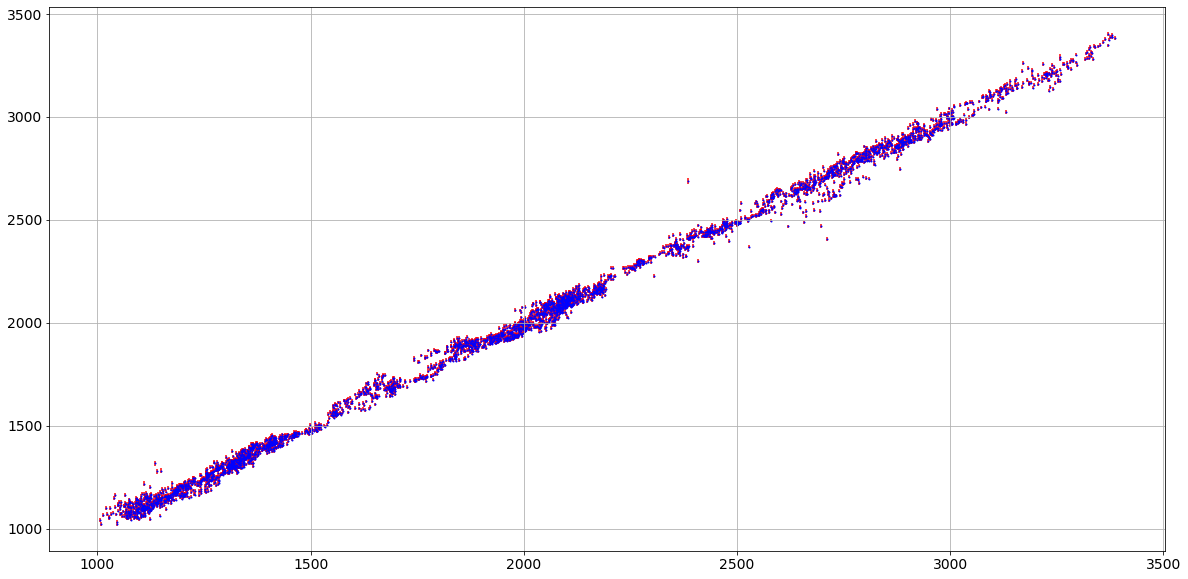

In [113]:
correlation_plot(df_finance['out'], y_pred1* scale + df_finance['out'].min(), y_err1 * scale, figsize=(20, 10))

Root mean squared error is: 31.607803485834175


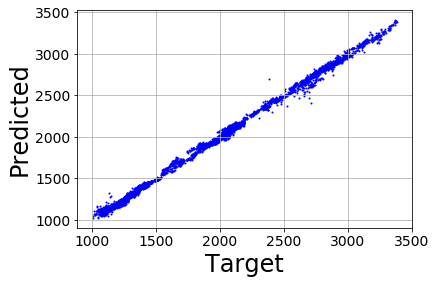

In [114]:
# Plot without Error
correlation_plot(df_finance['out'], y_pred1 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted')
# plot_for_paper(df_finance['out'], y_pred1 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted', name='1dhdmr.png', save=True)

In [115]:
# Creates and trains the 2d-hdmr model
d = data_scaled.shape[1] - 1
matrices2, kernels2 = kernel_matrices(2, d, length_scale=0.6)
hdmr2 = RSHDMRGPR(matrices2, kernels2)
hdmr2.train(x_train.drop(columns=['out']), y_train, alphas=1e-6, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 89.57 seconds.


In [116]:
y_pred2, y_err2 = hdmr2.predict(data_scaled.drop(columns=['out']), return_std=True)

Root mean squared error is: 14.734886338779779


<Figure size 1440x720 with 0 Axes>

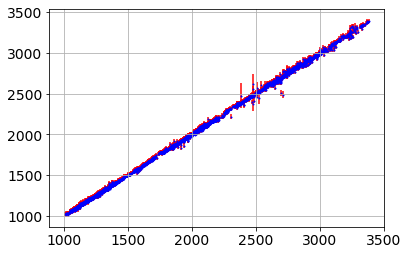

In [117]:
plt.figure(figsize=(20, 10))
correlation_plot(df_finance['out'], y_pred2* scale + df_finance['out'].min(), y_err2 * scale)

Root mean squared error is: 14.734886338779779


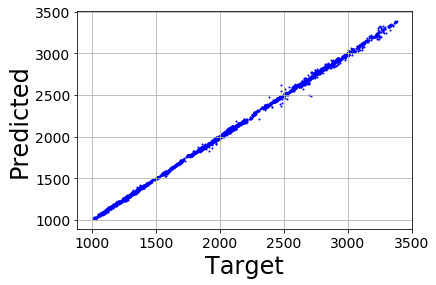

In [118]:
correlation_plot(df_finance['out'], y_pred2 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted')
# plot_for_paper(df_finance['out'], y_pred2 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted', name='2dhdmr.png', save=True)

In [119]:
# Trains the full D hdmr model using RSHDMRGPR class
d = data_scaled.shape[1] - 1
matricesf, kernelsf = kernel_matrices(d, d, length_scale=0.6)
hdmrf = RSHDMRGPR(matricesf, kernelsf)
hdmrf.train(x_train.drop(columns=['out']), y_train, alphas=1e-6, cycles=5, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 0.11 seconds.


In [120]:
y_predf, y_errf = hdmrf.predict(data_scaled.drop(columns=['out']), return_std=True)

Root mean squared error is: 16.695544611164223


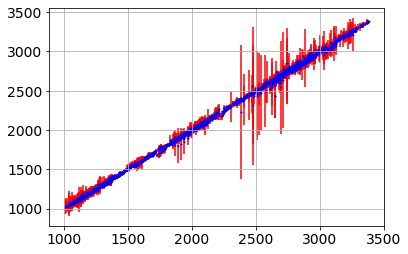

In [121]:
# Plots the correlation and error
correlation_plot(df_finance['out'], y_predf * scale + df_finance['out'].min(), y_err=y_errf * scale)

Root mean squared error is: 16.695544611164223


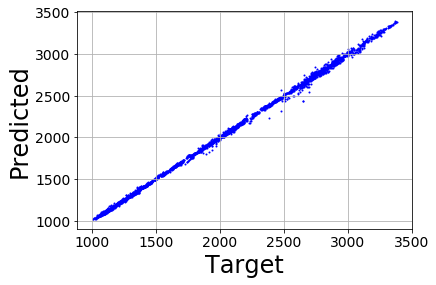

In [122]:
correlation_plot(df_finance['out'], y_predf * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted')
# plot_for_paper(df_finance['out'], y_predf * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted', name='fulldhdmr.png', save=True)

In [123]:
# 3d-hdmr model (training takes a while)
d = data_scaled.shape[1] - 1
matrices3, kernels3 = kernel_matrices(3, d, length_scale=0.7)
hdmr3 = RSHDMRGPR(matrices3, kernels3)
hdmr3.train(x_train.drop(columns=['out']), y_train, alphas=1e-6, scale_down=(0.1, 1), verbose=2)

Training completed. Total time for training is 330.36 seconds.


In [124]:
y_pred3 = hdmr3.predict(data_scaled.drop(columns=['out']))

Root mean squared error is: 14.333368012495116


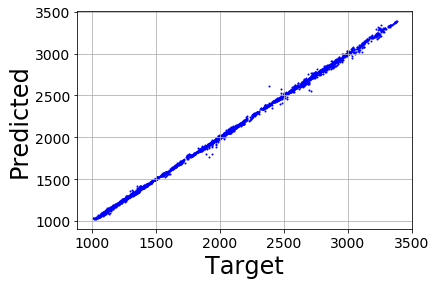

In [125]:
correlation_plot(df_finance['out'], y_pred3 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted')
# plot_for_paper(df_finance['out'], y_pred2 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted', name='3dhdmr.png', save=True)

In [126]:
data_scaled.shape

(3927, 15)

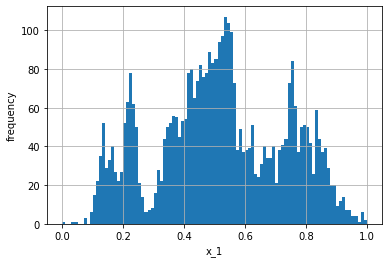

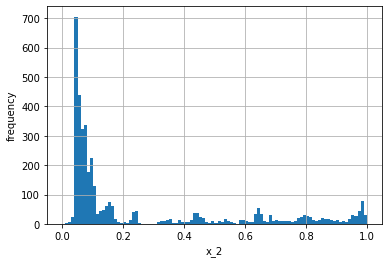

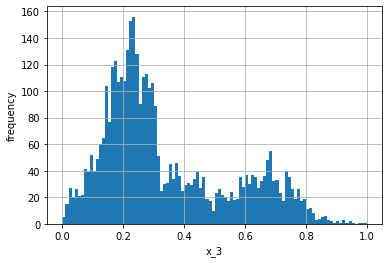

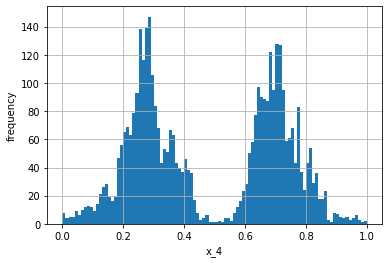

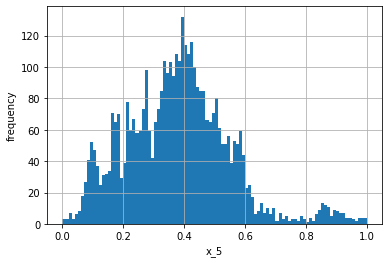

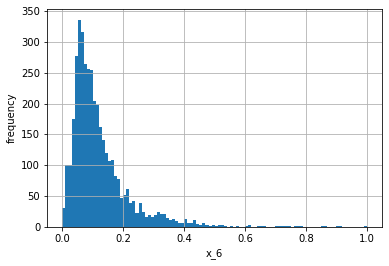

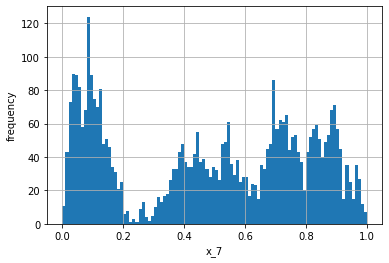

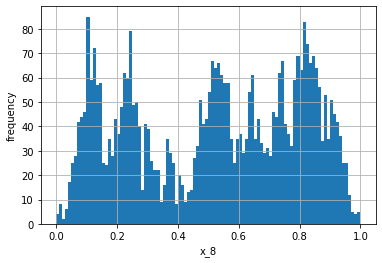

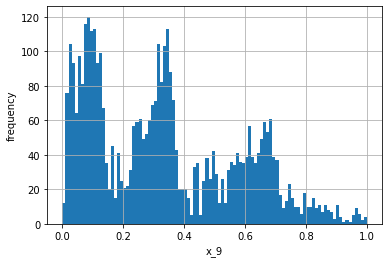

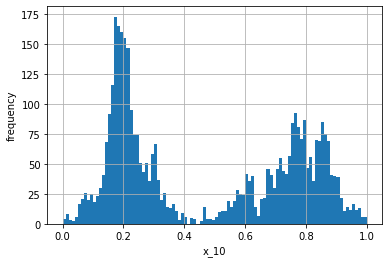

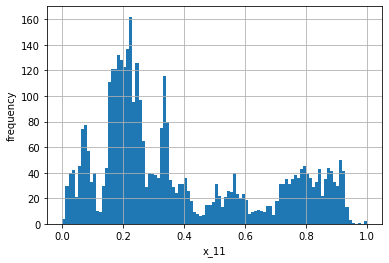

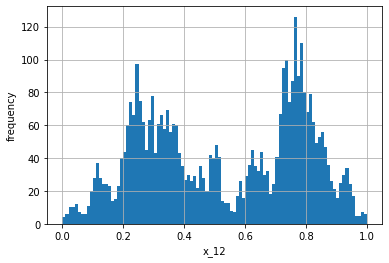

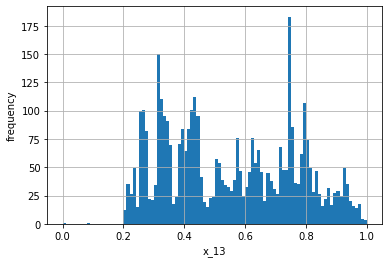

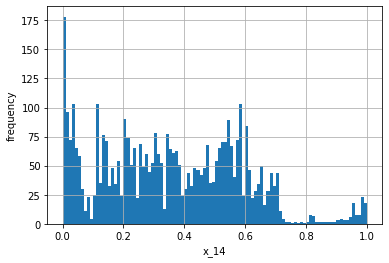

In [127]:
# Plots the distributions of the features.
for i in range(14):
    plt.figure()
    plt.xlabel(f'x_{i+1}')
    plt.ylabel('frequency')
    data_scaled.iloc[:, i].hist(bins=100)
    plt.show()
#     plt.savefig(f'Hist x_{i+1}.png', dpi=800, bbox_inches='tight')

In [128]:
models = hdmr1.get_models()

In [129]:
def f(x, i):
    return models[i].predict(np.array([[x]]))[0]
f = np.vectorize(f)

In [130]:
column_names = data_scaled.columns.tolist()

Root mean squared error is: 0.5262812907199486


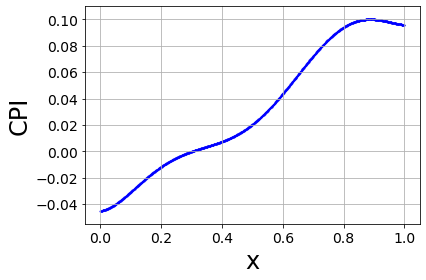

Root mean squared error is: 0.5232311574468614


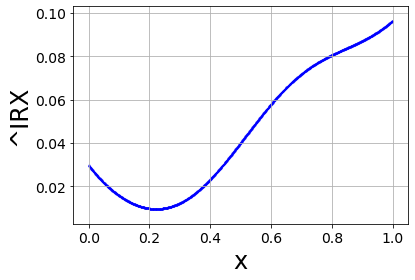

Root mean squared error is: 0.5400595112022216


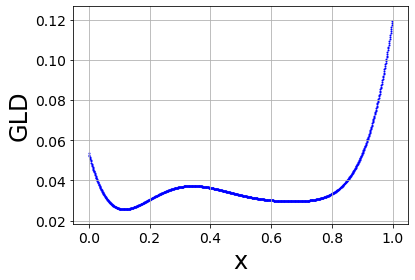

Root mean squared error is: 0.5565358447158228


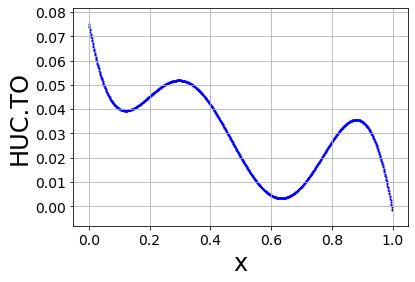

Root mean squared error is: 0.5142797898774184


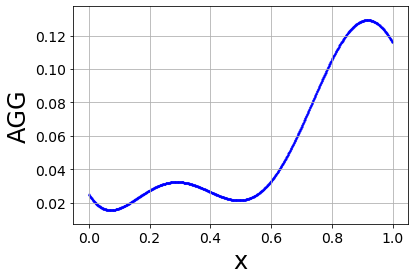

Root mean squared error is: 0.5615454717470743


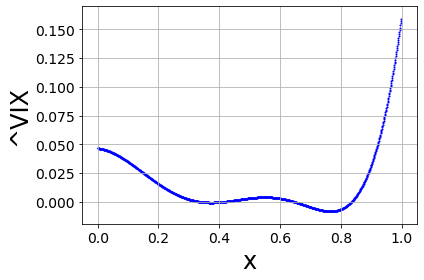

Root mean squared error is: 0.534107673561452


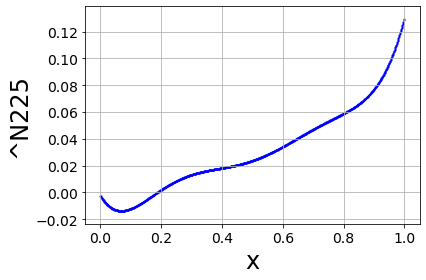

Root mean squared error is: 0.5375522838263845


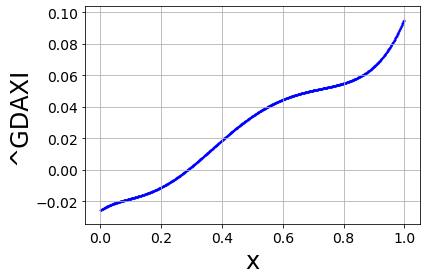

Root mean squared error is: 0.49609418377155023


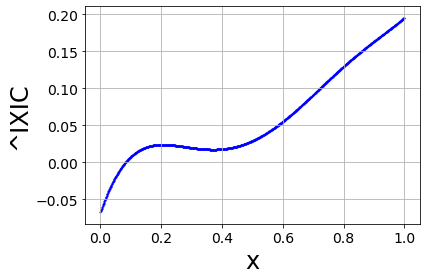

Root mean squared error is: 0.5546763045440314


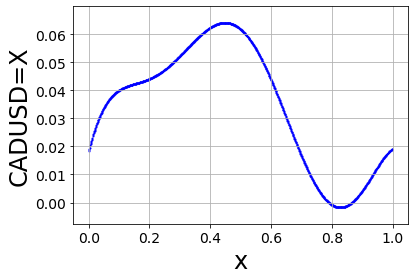

Root mean squared error is: 0.5733603055901149


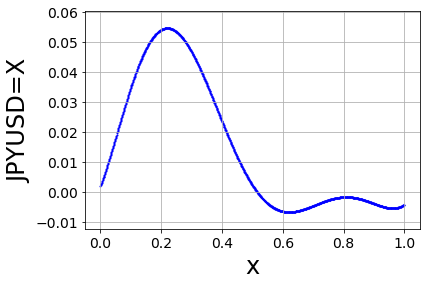

Root mean squared error is: 0.5460032463502884


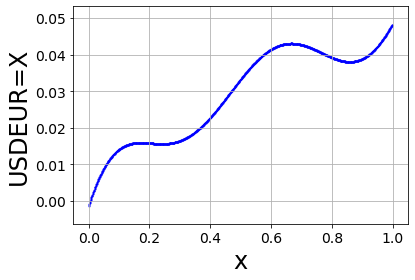

Root mean squared error is: 0.5451620397885735


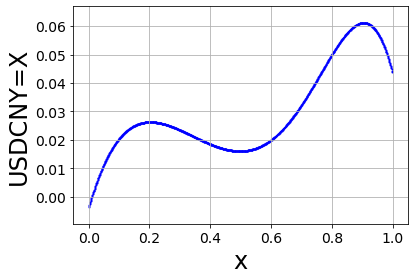

Root mean squared error is: 0.5067534312278096


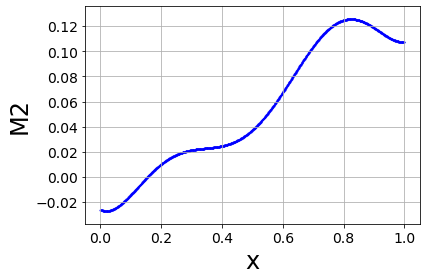

In [131]:
# Plots the hdmr component functions
x = np.arange(0, 1, 0.001)
for i in range(14):
    correlation_plot(x, f(x, i), xlabel='x', ylabel=column_names[i])
#     plot_for_paper(x, f(x, i), xlabel='x', ylabel=column_names[i], name=f'Component_{i}.png', save=True)

In [132]:
# Plots the imputation candidates for the financial features.
def test_impute(col=2):
    """
    Plots the imputation choices for the financial features
    """
    x_train_na = x_train.copy()
    x_train_na.iloc[np.arange(0, 200, 2), col] = np.nan
    df_na = x_train_na.copy()
    
    foimp = FirstOrderHDMRImpute(models=models)
    foimp.get_yi(df_na)
    
    _, nan_rows_index, null_entry, candidates = foimp.impute(df_na, get_candidates=True, threshold=0)
    
    true = x_train.iloc[np.arange(0, 200, 2), col]
    
    correct = []
    correct_idxs = []
    for i in range(true.shape[0]):
        true_val = true.iloc[i]
        closests = []
        for j in candidates[i]:
            closests.append(abs(j - true_val))
        idx = closests.index(min(closests))
        correct_idxs.append(idx)
        correct.append(candidates[i][idx])
    
    t = []
    im = []
    c = []
    m = 0
    choices = pd.DataFrame(columns=['true', 'imputed', 'correct'])
    for i in range(len(correct)):
        can = candidates[i]
        t.extend([true.iloc[i]] * len(can))
        c.extend([False] * len(can))
        for j in range(len(can)):
            im.append(can[j])
        c[m + correct_idxs[i]] = True
        m += len(can)
    choices['true'] = t
    choices['imputed'] = im
    choices['correct'] = c
    
    false_choices = choices[choices['correct'] == False]
    true_choices = choices[choices['correct'] == True]
    
    print(math.sqrt(mean_squared_error(true_choices['true'], true_choices['imputed'])))
    plt.figure()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(f'Imputed x_{col+1}', fontsize=24)
    plt.ylabel(f'True x_{col+1}', fontsize=24)
    p1 = plt.scatter(false_choices['true'], false_choices['imputed'], c='r', s=3)
    p2 = plt.scatter(true_choices['true'], true_choices['imputed'], c='b', s=3)
    plt.grid()
    plt.legend((p1, p2), ('Incorrect', 'Correct'))
    plt.show()
#     plt.savefig(f'Impute_{col}.png', dpi=800, bbox_inches='tight')
    
    return x_train_na, df_na, false_choices, true_choices

Imputation function execution time took 5.704743146896362 seconds.
0.07200907418387595


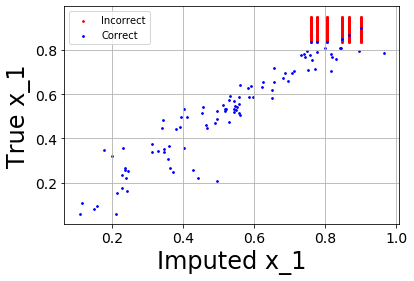

Imputation function execution time took 5.906219482421875 seconds.
0.16539905879961112


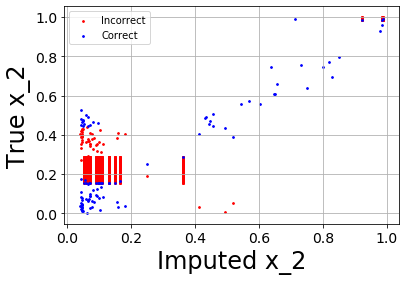

Imputation function execution time took 5.918171644210815 seconds.
0.24785388717298745


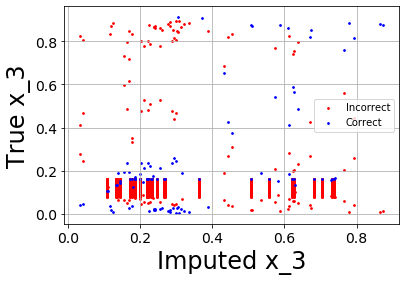

Imputation function execution time took 6.036855936050415 seconds.
0.17919804706253478


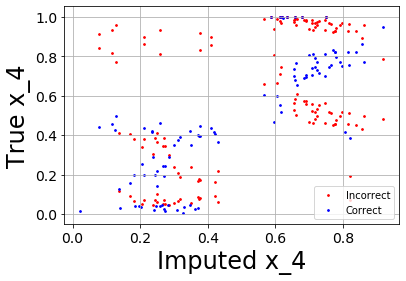

Imputation function execution time took 6.165510892868042 seconds.
0.19205132806395583


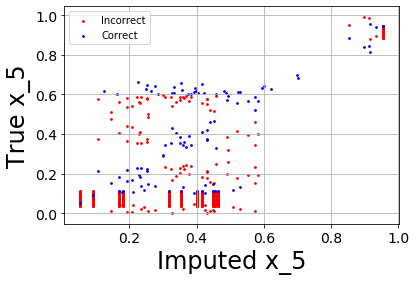

Imputation function execution time took 6.325084209442139 seconds.
0.4070382536695759


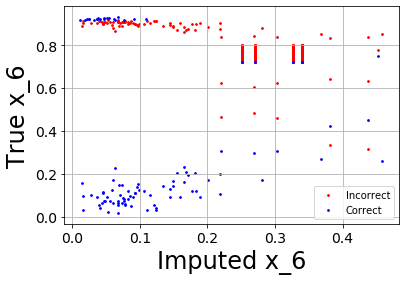

Imputation function execution time took 6.468699216842651 seconds.
0.09011744343758496


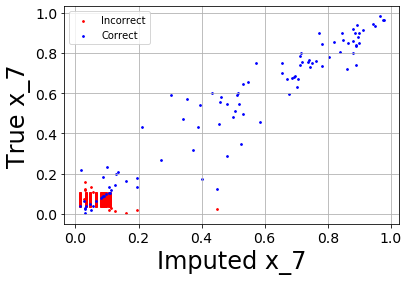

Imputation function execution time took 5.812454462051392 seconds.
0.10840621317588396


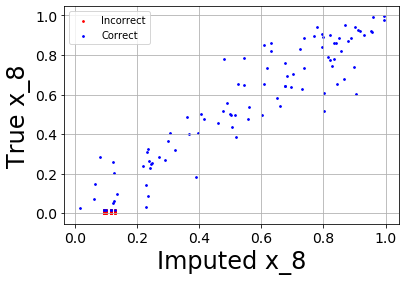

Imputation function execution time took 6.2343268394470215 seconds.
0.13000797805814537


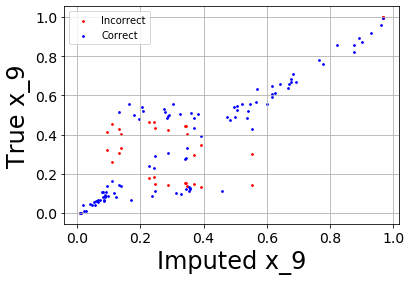

Imputation function execution time took 5.6518847942352295 seconds.
0.08710521695682531


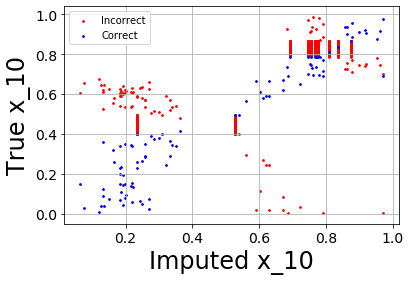

Imputation function execution time took 5.681804895401001 seconds.
0.11807892936632684


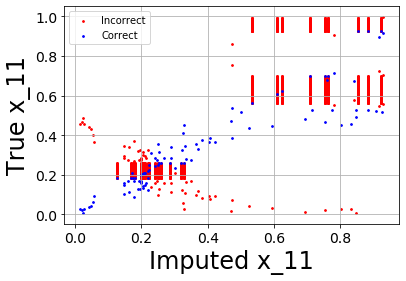

Imputation function execution time took 5.764576435089111 seconds.
0.2256687058345325


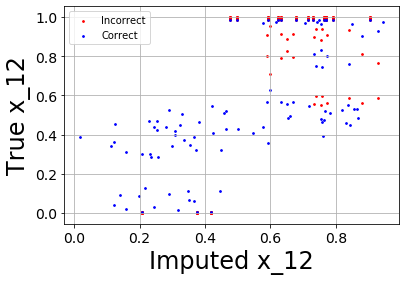

Imputation function execution time took 6.68312668800354 seconds.
0.2643179801650804


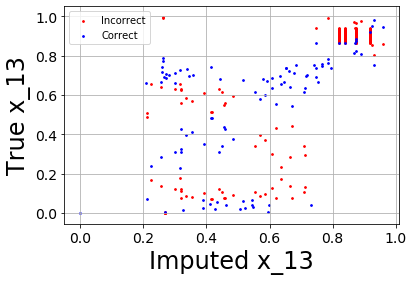

Imputation function execution time took 6.012920141220093 seconds.
0.1014046141036706


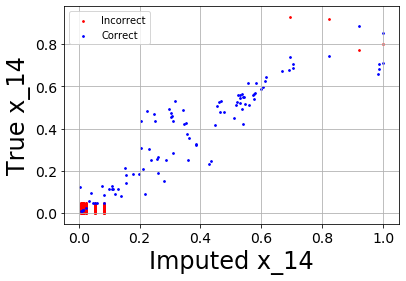

In [133]:
for i in range(14):
    _ = test_impute(i)